In [1]:
%run Structure.ipynb
%run Aero.ipynb
from types import SimpleNamespace

In [2]:
class Environment():
    def __init__(self, aero_model, ref_ground_wind, latitude=32):
        self.up = np.array([0,0,1])
        self.project_normal = np.identity(3) - np.outer(self.up, self.up)
        self.ka        = 1.4                   # Ratio of specific heats, air  
        self.Ra        = 287.058                 # Avg. specific gas constant (dry air)
        self.latitude  = np.radians(latitude) # degrees north, launch site
        self.earth_rad = 6371000 # m
        self.mu_earth  = 3.986004418 * 10**14 # m^3/s^2, earth gravitational parameter
        
        # International Gravity Formula (IGF) 1980, Geodetic Reference System 1980 (GRS80)
        self.IGF    = 9.780327 * (1 + 0.0053024 * np.sin(self.latitude)**2 - 0.0000058 * np.sin(2*self.latitude)**2)
        # Free Air Correction (FAC)
        self.FAC    = -3.086 * 10**(-6)
        
        # for coriolis accel
        self.sinlat = np.sin(self.latitude)
        self.coslat = np.cos(self.latitude)
        self.erot   = 7.2921150e-5 # Sidearial Earth rotation rate
        
        #openrocket method for gravitational accel, open rocket uses 6371000 m for earth radius
        # comparing is low priority
        #sin2lat = self.sinlat**2
        #self.g_0 = 9.7803267714 * ((1.0 + 0.00193185138639 * sin2lat) / np.sqrt(1.0 - 0.00669437999013 * sin2lat))
        
        self.aero_model = aero_model
        
        # initialize atmospheric model, is it worth calculating this once and for all?
        T_0 = 288.15 # K
        p_0 = 101325 # Pa
        self.layer =  [0, 11000, 20000, 32000, 47000, 51000, 71000, 84852,
                       90000, 100000, 110000, 120000, 130000, 140000, 150000, 160000]
        self.baseTemp = [288.15, 216.65, 216.65, 228.65, 270.65, 270.65, 214.65, 186.95,
                         196.86, 203.06, 224.28, 250.09, 285.13, 364.19, 441.79, 517.94]
        self.basePress = [p_0]
        for i, alt in enumerate(self.layer):
            if i == 0:
                pass
            else:
                self.basePress.append(self.getConditions(self.layer[i] - 1)[1])
        
        # references for wind model < 150 m
        self.u_0   = ref_ground_wind
        self.z_0   = 18.3
        self.alpha = 1.21 * self.u_0**(-0.75)
                
    # https://github.com/openrocket/openrocket/blob/b5cde10824440a1e125067b7d149873deec424b4/core/src/net/sf/openrocket/util/GeodeticComputationStrategy.java
    # double check, low priority. might not even need
    def coriolis(self, v):
        v_e = v[0] # note, pretty sure openrocket does this wrong by adding a negative sign here
        v_n = v[1]
        v_u = v[2]
        acc = -2*self.erot*np.cross(np.array([0, self.coslat, self.sinlat]), v)
        return acc # acceleration
    
    # https://www.sensorsone.com/local-gravity-calculator/
    # maybe one day i'll use this alternative https://github.com/openrocket/openrocket/blob/unstable/core/src/net/sf/openrocket/models/gravity/WGSGravityModel.java
    def g_accel(self, x):
        return np.array([0, 0, -self.IGF + self.FAC * x[-1]])
        #return self.g_0 * (6356766/(6356766 + x[-1]))**2
        
    # gravitational torque. inputs in inertial frame, outputs in body frame
    def T_gg(self, x, attitude_BI, J):
        r = np.linalg.norm(x)
        height = r + self.earth_rad
        n = frame_rotation(attitude_BI, - x / r)
        return (3 * self.mu_earth / height**3) * np.cross(n, J.dot(n)) # kg * m^2 / s^2

    # U.S. 1976 Standard Atmosphere, at some point compare more rigorously to openrocket's method, low priority
    #def old_std_at(self, x):
    #    if x[2] < 11000:
    #        T = 15.04 - 0.00649*x[2]
    #        p = 101.29*((T + 273.1)/288.08)**5.256
    
    #    elif 11000 <= x[2] and x[2] <25000:
    #        T = -56.46
    #        p = 22.65*np.exp(1.73 - 0.000157*x[2])
    
    #    else:
    #        T = -131.21 + 0.00299*x[2]
    #        p = 2.488 * ((T + 273.1)/216.6)**(-11.388)
    
    #    p_a = p*1000                 # Ambient air pressure [Pa]
    #    rho = p/(0.2869*(T + 273.1)) # Ambient air density [kg/m^3]
    #    T_a = T + 273.1              # Ambient air temperature [K]
    #    return np.array([p_a, rho, T_a])
    
    # is there a more intelligent way to do this?
    # why are there two formulae?, med priority
    def getConditions(self, altitude):
        index = 0
        g = np.linalg.norm(self.g_accel([altitude]))
        altitude = altitude * 6356766 / (altitude + 6356766) # geopotential altitude
        for i in range(len(self.layer)-1):
            if self.layer[i + 1] > altitude:
                break
            index += 1
        rate = (self.baseTemp[index+1] - self.baseTemp[index])/(self.layer[index+1] - self.layer[index])
        t = self.baseTemp[index] + (altitude - self.layer[index])* rate
        if altitude > 95000:
            Ra = R_univ / 25 # kind of a hack. see miller '57 when you care
        else:
            Ra = self.Ra
        
        if abs(rate) > 0.001:
            p = self.basePress[index]*(1 + (altitude-self.layer[index])*rate/self.baseTemp[index])**(-g/(rate*Ra))
        else:
            p = self.basePress[index]*(np.exp(-(altitude-self.layer[index])* g / (Ra * self.baseTemp[index])))
        return (t, p)
    
    def std_at(self, x):
        T_a, p_a = self.getConditions(x[-1])
        # you know this is a poor method for checking conditions, med priority
        if self.Ra == 287.058 and x[-1] > 95000:
            self.Ra = R_univ / 25 # rough estimate when you care, see
            # Miller, L. E. (1957). “Molecular weight” of air at high altitudes, low priority

        rho = p_a/(self.Ra*T_a) # Ambient air density [kg/m^3]
        mu = 3.7291*10**-6 + 4.9944*10**-8 * T_a / rho # kinematic viscosity
        return np.array([p_a, rho, T_a, mu])
    
    # calculates drag force, etc
    def aero(self, state, rkt, air, wind):
        x, q, v, w = state[1:]
        roll = w[2]
        p_a, rho, T_a, mu = air
        
        # Check Knudsen number and consider other drag models (e.g. rarified gas dyn vs. quadratic drag), low priority
        v0 = np.linalg.norm(v - wind)
        v_hat = normalize(v - wind)
        v_body = frame_rotation(q, v_hat)
        
        alpha = np.arccos(np.clip(np.dot(v_body, self.up), -1, 1))
        sound_speed = np.sqrt(self.ka * self.Ra * T_a)
        fin_flutter = self.aero_model.flutter_velocity(sound_speed, p_a) * 0.85 # 15% factor of safety
        Ma = v0 / sound_speed # Mach
        #Ma = v0 / (165.77 + 0.606*T_a) # openrocket's approx, < 1% error at low altitude, around 5-7% at high, low priority
        dyn_press = 0.5 * rho * v0**2         # Dynamic pressure [Pa]
        
        # HIGH priority, get parasitic drag from fuel piping :(
        # at some point include an option for the old look up table here, med priority
        # also med priority, but a simple planform calculation for CoP could be useful for low-fidelity model
        # low priority, consider "Active Control Stabilization of High Power Rocket" for drag equations
        CoP, CN, CDax, Cld_times_d, C_damp_p, C_damp_y = self.aero_model.physics(alpha, Ma, v0, w, mu, rkt.CoM[2])
        CoP = np.array([0,0, rkt.length - CoP]) # CoP calculated nose ref, but we work base ref
        
        direction = -normalize(self.project_normal.dot(v_body)) # normalize might be unnecessary
        norm_force= CN*direction
        
        if not rkt.off_tower:# or v[2] <= 0:
            norm_force *= 0
            Cld_times_d = 0
            
        pitch_moment = np.cross(CoP - rkt.CoM, norm_force)
        #C_damp_p = min(C_damp_p, pitch_moment[0])
        #C_damp_y = min(C_damp_y, pitch_moment[1])
        pitch_damp   = np.array([C_damp_p * np.sign(w[0]), C_damp_y * np.sign(w[1]), 0])
        #print(pitch_moment, ',  ',pitch_damp)
        mult = dyn_press * rkt.frontal_area
        force_body = (np.array([0, 0, -CDax]) + norm_force) * mult
        torque_body = (np.array([0, 0, -Cld_times_d]) +
                       pitch_moment - pitch_damp#+
                       #np.array([np.random.uniform(-0.0005,0.0005),
                       #         np.random.uniform(-0.0005,0.0005), 0]) # openrocket injects noise for realism
                      ) * mult
        
        return np.array([force_body, torque_body, v0, dyn_press, Ma, alpha, CoP[2], fin_flutter])
    
    # https://en.wikipedia.org/wiki/Wind_profile_power_law
    # assuming stable atmosphere over land without too rough
    # of terrain and wind measurements at 10 m
    def ground_wind_profile(self, z):
        if z < 0: z = 0
        if z > 150: z = 150
        return self.u_0 * (z / self.z_0)**self.alpha
    
    def wind_vector(self, x):
        magnitude = self.ground_wind_profile(x[2] - launch_site_alt)
        return np.array([1, 0, 0]) * magnitude

# state = [m, x, q, v, w], is it an issue that our CoM changes but we still use F=MA?
# parameters = [mdot, thtl, I_body, forces, torques], is it a sin to not update MoI as a state variable?
# reference (7.233) on page 435 of Shabana for dynamical equations
def derivatives(state, parameters):
    def dm_dt(mdot, throttle):
        return -mdot*throttle
    
    # kinematic equations of motion
    def dx_dt(v):
        return v
    
    def dq_dt(q, w):
        return 1/2 * product(q, np.array([0, w[0], w[1], w[2]]))
    
    # dynamical equations of motion
    def dv_dt(mass, forces, accels):
        return accels + forces / mass
    
    def dw_dt(J_body, w, torque):
        return np.linalg.inv(J_body).dot(torque - np.cross(w, J_body.dot(w)))
    
    return np.array([dm_dt(parameters[0], parameters[1]),
                     dx_dt(state[3]),
                     dq_dt(state[2], state[4]),
                     dv_dt(state[0], parameters[3], parameters[4]),
                     dw_dt(parameters[2], state[4], parameters[5])])
    
def dynamics(env, rkt, state, param):
    wind      = np.zeros(3)#env.wind_vector(state[1]) #np.zeros(3) # find a nice deterministic profile, high priority
    air       = env.std_at(state[1])
    aero      = env.aero(state, rkt, air, wind)
    
    grav_acc  = env.g_accel(state[1])
    grav_torq = env.T_gg(state[1], state[2], rkt.moment)
    
    if rkt.has_fuel():
        throttle = rkt.engine.throttle_engine(np.linalg.norm(aero[0])) # still need a better method, low priority
        thrust   = rkt.engine.thrust(air[0], throttle)
    else:
        throttle = 0.
        thrust   = 0.
        
    forces = sandwich(state[2], sum([aero[0], np.array([0, 0, thrust]), param[0]])) # put forces in inertial frame
    accels = sum([grav_acc, env.coriolis(state[3])])
    torque = sum([grav_torq, aero[1], param[1]])
    return np.array([forces, accels, torque, throttle, air, aero, thrust])

# parameters = [C_d, T_param]
def runge_kutta(env, rkt, state, parameters, dt):
    mdot = rkt.engine.mdot if rkt.has_fuel() else 0
    F1 = dynamics(env, rkt, state, parameters)
    k1 = derivatives(state, [mdot, F1[3], rkt.moment, F1[0], F1[1], F1[2]])
    
    state_2 = [sum(pair) for pair in zip(state, dt*k1/2)]
    state_2[2] = normalize(state_2[2])
    F2 = dynamics(env, rkt, state_2, parameters)
    k2 = derivatives(state_2, [mdot, F2[3], rkt.moment, F2[0], F2[1], F2[2]])
    
    state_3 = [sum(pair) for pair in zip(state, dt*k2/2)]
    state_3[2] = normalize(state_3[2])
    F3 = dynamics(env, rkt, state_3, parameters)
    k3 = derivatives(state_3, [mdot, F3[3], rkt.moment, F3[0], F3[1], F3[2]])
    
    state_4 = [sum(pair) for pair in zip(state, dt*k3)]
    state_4[2] = normalize(state_4[2])
    F4 = dynamics(env, rkt, state_4, parameters)
    k4 = derivatives(state_4, [mdot, F4[3], rkt.moment, F4[0], F4[1], F4[2]])
    
    return ((k1 + 2*k2 + 2*k3 + k4) / 6,
            (F1 + 2*F2 + 2*F3 + F4) / 6,
            None)

# parameters = [C_d, T_param]
# http://maths.cnam.fr/IMG/pdf/RungeKuttaFehlbergProof.pdf
def adaptive_runge_kutta(env, rkt, state, parameters, dt):
    mdot = rkt.engine.mdot if rkt.has_fuel() else 0
    F1 = dynamics(env, rkt, state, parameters)
    k1 = derivatives(state, [mdot, F1[3], rkt.moment, F1[0], F1[1], F1[2]])
    
    state_2 = [sum(pair) for pair in
               zip(state, dt[-1]*k1/4)]
    state_2[2] = normalize(state_2[2])
    F2 = dynamics(env, rkt, state_2, parameters)
    k2 = derivatives(state_2, [mdot, F2[3], rkt.moment, F2[0], F2[1], F2[2]])
    
    state_3 = [sum(pair) for pair in
               zip(state, dt[-1] *(3*k1 + 9*k2)/32)]
    state_3[2] = normalize(state_3[2])
    F3 = dynamics(env, rkt, state_3, parameters)
    k3 = derivatives(state_3, [mdot, F3[3], rkt.moment, F3[0], F3[1], F3[2]])
    
    state_4 = [sum(pair) for pair in
               zip(state, dt[-1]*(1932*k1 - 7200*k2 + 7296*k3)/2197)]
    state_4[2] = normalize(state_4[2])
    F4 = dynamics(env, rkt, state_4, parameters)
    k4 = derivatives(state_4, [mdot, F4[3], rkt.moment, F4[0], F4[1], F4[2]])
    
    state_5 = [sum(pair) for pair in
               zip(state, dt[-1]*(439*k1/216 - 8*k2 + 3680*k3/513 - 845*k4/4104))]
    state_5[2] = normalize(state_5[2])
    F5 = dynamics(env, rkt, state_5, parameters)
    k5 = derivatives(state_5, [mdot, F5[3], rkt.moment, F5[0], F5[1], F5[2]])
    
    state_6 = [sum(pair) for pair in
               zip(state, dt[-1]*(-8*k1/27 + 2*k2 - 3544*k3/2565 + 1859*k4/4104 - 11*k5/40))]
    state_6[2] = normalize(state_6[2])
    F6 = dynamics(env, rkt, state_6, parameters)
    k6 = derivatives(state_6, [mdot, F6[3], rkt.moment, F6[0], F6[1], F6[2]])
    
    order_5 = state + dt[-1] * (16*k1/135 + 6656*k3/12825 + 28561*k4/56430 - 9*k5/50 + 2*k6/55)
    order_5[2] = normalize(order_5[2])
    return (25*k1/216 + 1408*k3/2565 + 2197*k4/4101 - k5/5,
            25*F1/216 + 1408*F3/2565 + 2197*F4/4101 - F5/5,
            order_5)

def time_step(env, rkt, state, dt, state_list):
    if rcs_control and len(state_list) > 1:
        num_thrusters, rcs_force, rcs_torque = rkt.rcs.controller(state[2], state_list[-1][1][1][4][0], rkt.CoM)
    else:
        num_thrusters, rcs_force, rcs_torque = 0, np.zeros(3), np.zeros(3)
        
    # may even want this up one more step in the hierarchy
    parameters = [rcs_force, rcs_torque]
    
    if rkt.adaptive:
        update = adaptive_runge_kutta(env, rkt, state, parameters, dt)
    else:
        update = runge_kutta(env, rkt, state, parameters, dt)
        
    new = state + dt[-1] * update[0]
    new[2] = normalize(new[2])
    
    # at some point, adjust this to account for position being at CoM, low priority
    if (new[1][2] - state_list[0][0][1][2] >= launch_tower and
                    state[1][2] - state_list[0][0][1][2] < launch_tower):
        rkt.off_tower = True
        rkt.tower_index = len(state_list) + 1
        rkt.launch_speed = np.linalg.norm(new[3])
        
    # at some point organize this logic, med priority
    if rkt.has_fuel():
        rkt.kludge = True
    else:
        if rkt.kludge:
            rkt.kludge = False
            rkt.F_index = len(state_list) - 1
    
    rkt.rcs.parts[0].drain(num_thrusters*rkt.rcs.mdot * dt[-1])
    rkt.rcs.parts[1].exhaust_velocity(rkt.rcs.pressure())
    
    del_m_o, del_m_f = proportion(dt[-1]*update[0][0], rkt.OF)
    rkt.lox_tank.drain(del_m_o)
    rkt.ipa_tank.drain(del_m_f)
    
    rkt.sum_parts()
    stability_margin = (rkt.CoM[2] - update[1][5][6]) / rkt.diameter
    
    if not rkt.adaptive:
        m_prop = rkt.lox_tank.parts[-1].mass + rkt.ipa_tank.parts[-1].mass
        openrocket_CoM = rkt.eng_sys.CoM[2] # for openrocket engine
    else:
        m_prop, openrocket_CoM = None, None
    
    if rkt.adaptive:
        diff = 2 * sqrt(sum([np.linalg.norm(i)**2 for i in (update[-1] - new)]))
        rkt.error.append(diff/2)
        dt.append(dt[-1] * (rkt.tol/diff)**.25)
     
    state_list.append((new, update[:-1], stability_margin, m_prop, openrocket_CoM))

def integration(env, rkt, dt, descend):
    stop = False
    env.first_time_env = True
    rkt.off_tower = False
    rkt.error = []
    state_list = []
    rkt.dt = [dt]
    rkt.F_index = 2
    quat = np.array([0.9990482, 0, 0.0436194, 0 ])#np.array([1,0,0,0])# # 10 degree angle normalize(np.array([0.9961947, 0, 0.0871557, 0]))
    initial_state = np.array([rkt.mass, np.array([0,0, launch_site_alt]), quat, np.zeros(3), np.zeros(3)])
    state_list.append((initial_state, 0)) # kludge, at some point clean initialization up. low priority
    
    time_step(env, rkt, state_list[-1][0], rkt.dt, state_list)
    while (not descend and state_list[-1][0][3][2] > 0) or (descend and state_list[-1][0][1][2] > launch_site_alt):
        time_step(env, rkt, state_list[-1][0], rkt.dt, state_list)
    
    return state_list

In [3]:
# array breakdown:
# state_list[i]: (state, update, stability_margin, m_prop, openrocket_CoM)
#   state: (m, x, q, v, w)
#   update: (derivatives, dynamics)
#     derivatives: see state
#     dynamics: (forces, accels, torque, throttle, air, aero, thrust)
#       air: (p_a, rho, T_a, mu)
#       aero: (force_body, torque_body, v0, dyn_press, Ma, alpha, CoP[2], flutter)

def trajectory(m_prop, mdot, p_e,
               throttle_window, min_throttle,
               rcs_mdot, rcs_p_e, rcs_p_ch,
               ballast, root, tip, sweep, span, thickness,
               airfrm_in_rad, OF, p_ch, T_ch, ke, MM,
               dt, adaptive=False, tol=0.042, descend=False):
    
    LV4 = create_rocket(m_prop, mdot, p_e,
                    p_ch, T_ch, ke, MM,
                    throttle_window, min_throttle,
                    airfrm_in_rad, OF,
                    rcs_mdot, rcs_p_e, rcs_p_ch,
                    ballast, root, tip, sweep, span, thickness)
    aero_model = AeroModel(LV4.diameter, LV4.length, nose_l,
                           LV4.fin)
    env = Environment(aero_model, 17.7)
    LV4.adaptive = adaptive
    LV4.tol = tol
    states = integration(env, LV4, dt, descend)
    
    sim = SimpleNamespace()
    sim.raw_states = states
    sim.LV4 = LV4
    sim.launch_speed = LV4.launch_speed
    sim.F_index = LV4.F_index - 1 # subtract one cus we're throwing away the first entry. pardon the kludge
    sim.alt = []
    sim.v = []
    sim.a = []
    sim.thrust = []
    sim.drag = []
    sim.dyn_press = []
    sim.p_a = []
    sim.rho = []
    sim.t = []
    sim.Ma = []
    sim.m = []
    sim.throttle = []
    sim.stability_margin = []
    sim.m_prop = []
    sim.openrocket_CoM = []
    sim.fin_flutter = []
    
    for i, state in enumerate(states[1:]):
        sim.alt.append(state[0][1][2])
        sim.v.append(state[0][3][2])
        sim.a.append(state[1][0][3][2])
        sim.thrust.append(state[1][1][6])
        sim.drag.append(abs(state[1][1][5][0][2]))
        sim.dyn_press.append(state[1][1][5][3])
        sim.fin_flutter.append(state[1][1][5][7] / state[0][3][2])
        sim.p_a.append(state[1][1][4][0])
        sim.rho.append(state[1][1][4][1])
        sim.t.append(i*dt) # kludge? add time as a state variable, low priority
        sim.Ma.append(state[1][1][5][4])
        sim.m.append(state[0][0])
        sim.throttle.append(state[1][1][3])
        sim.stability_margin.append(state[2])
        sim.m_prop.append(state[3])
        sim.openrocket_CoM.append(state[4])
    
    sim.alt = np.array(sim.alt)
    sim.v = np.array(sim.v)
    sim.a = np.array(sim.a)
    sim.thrust = np.array(sim.thrust)
    sim.drag = np.array(sim.drag)
    sim.dyn_press = np.array(sim.dyn_press)
    sim.p_a = np.array(sim.p_a)
    sim.rho = np.array(sim.rho)
    sim.t = np.array(sim.t)
    sim.fin_flutter = np.array(sim.fin_flutter)
    
    # note g_n is a global constant in inputs
    # this will run after we reach apogee to do last-minute calculations and conversions
    sim.TWR = sim.a[0] / g_n                  # Thrust-to-weight ratio constraint
    sim.S_crit = LV4.engine.p_e / sim.p_a[0]         # Sommerfield criterion constraint
    sim.massratio = LV4.GLOW / sim.m[-1] # Mass ratio
    sim.dV1 = LV4.engine.Ve * np.log(sim.massratio) / 1000            # Tsiolkovsky's bane (delta-V)
    sim.max_g_force = max(abs(sim.a)) / g_n   # calculates top g-force
    sim.maxq = max(sim.dyn_press)
    # ignoring the end of flight stability cuz it doesn't really matter
    sim.min_stability = min(sim.stability_margin[:sim.F_index])
    sim.min_fin_flutter = min(sim.fin_flutter[:sim.F_index])
    sim.ld_ratio = sim.LV4.length / sim.LV4.diameter
    
    return sim

In [4]:
# this creates a list of strings for relevant data of trajectory
# arranging in sensible order is low priority. there might be more information to extract also.
# maybe get input from on high about most relevant info and how to organize it nicely
def print_results(sim, save):
    text_base = []
    text_base.append('\nDESIGN VECTOR')
    text_base.append('\n-----------------------------')
    text_base.append('\ndesign total propellant mass               = {:.3f} kg'.format(sim.m_prop[0]))
    text_base.append('\ndesign mass flow rate                      = {:.3f} kg/s'.format(sim.LV4.engine.mdot))
    text_base.append('\ndesign nozzle exit pressure                = {:.3f} Pa'.format(sim.LV4.engine.p_e))
    text_base.append('\ntotal tankage length (after adjustment)    = {:.3f} m'.format(sim.LV4.l_o + sim.LV4.l_f))
    text_base.append('\ndesign airframe diameter                   = {:.3f} m.'.format(sim.LV4.diameter))
    text_base.append('\ndesign airframe total length               = {:.3f} m.'.format(sim.LV4.length))
    text_base.append('\ndesign GLOW                                = {:.3f} kg'.format(sim.LV4.GLOW))
    text_base.append('\ndesign ballast mass                        = {:.3f} kg'.format(sim.LV4.ballast))
    text_base.append('\ndesign fin root chord                      = {:.3f} m'.format(sim.LV4.fin.root))
    text_base.append('\ndesign fin tip chord                       = {:.3f} m'.format(sim.LV4.fin.tip))
    text_base.append('\ndesign fin sweep angle                     = {:.3f} deg'.format(np.degrees(sim.LV4.fin.sweep)))
    text_base.append('\ndesign fin span                            = {:.3f} m'.format(sim.LV4.fin.height))
    text_base.append('\ndesign fin thickness                       = {:.3f} mm'.format(sim.LV4.fin.thickness*1000))
    
    text_base.append('\n')
    text_base.append('\nCONSTRAINTS')
    text_base.append('\n-----------------------------')
    text_base.append('\nL/D ratio (c.f. < {})                       = {:.3f}'.format(
                                                                            cons_LD, sim.ld_ratio))
    text_base.append('\nfin flutter ratio (c.f. > {})                       = {:.3f}'.format(
                                                                            1.0, sim.min_fin_flutter))
    text_base.append('\nSommerfield criterion (c.f. pe/pa >= {})    = {:.3f}'.format(cons_S_crit, sim.S_crit))
    text_base.append("\nmax acceleration (c.f. < {})                = {:.3f} gs".format(
                                                                                cons_accel, sim.max_g_force))
    text_base.append('\nTWR at lift off (c.f. > {})                 = {:.3f}'.format(cons_TWR, sim.TWR))
    text_base.append('\nLowest stability margin caliber (c.f. > {}) = {:.3f}'.format(cons_stblty, sim.min_stability))
    text_base.append('\nspeed when leaving launch rail (c.f. > {})  = {:.3f} m/s'.format(cons_ls, sim.launch_speed))
    text_base.append('\naltitude at apogee (c.f. > {})              = {:.3f} km'.format(
                                                                                cons_alt/1000, sim.alt[-1]/1000))
    text_base.append('\ndesign thrust (ground level) (c.f. < {})    = {:.3f} kN'.format(
                                                                                     cons_thrust, sim.thrust[0]/1000))

    text_base.append('\n')
    text_base.append('\nADDITIONAL INFORMATION')
    text_base.append('\n-----------------------------')
    text_base.append('\ndesign thrust (vacuum)                     = {:.2f} kN'.format(sim.thrust[sim.F_index]/1000))
    text_base.append('\ndesign total dry mass                      = {:.3f} kg'.format(sim.m[-1]))
    text_base.append('\nmission time at apogee                     = {:.3f} s'.format(sim.t[-1]))
    text_base.append('\nmission time at burnout                    = {:.3f} s'.format(sim.t[sim.F_index]))
    text_base.append('\nmax dynamic pressure                       = {:.3f} kPa'.format(sim.maxq/1000))
    text_base.append('\ndesign dV                                  = {:.3f} km/s'.format(sim.dV1))
    text_base.append('\nestimated minimum required dV              = {:.3f} km/s'.format(
                                                                                    sqrt(2*g_n*sim.alt[-1])/1000))
    
    text_base.append("\n")
    text_base.append("\nENGINE SYSTEM DETAILS")
    text_base.append("\n-----------------------------")
    mdot_o, mdot_f = proportion(sim.LV4.engine.mdot, sim.LV4.OF)
    text_base.append("\nOx flow:                                   = {:.3f} kg/s".format(mdot_o))
    text_base.append("\nFuel flow:                                 = {:.3f} kg/s".format(mdot_f))
    text_base.append("\nOx mass:                                   = {:.3f} kg".format(sim.LV4.m_o))
    text_base.append("\nFuel mass:                                 = {:.3f} kg".format(sim.LV4.m_f))
    text_base.append("\nOx tank length + ullage:                   = {:.3f} m".format(sim.LV4.l_o))
    text_base.append("\nFuel tank length + ullage:                 = {:.3f} m".format(sim.LV4.l_f))
    text_base.append('\ndesign chamber pressure                    = {:.3f} kPa'.format(sim.LV4.engine.p_ch/1000))
    text_base.append('\ndesign expansion ratio                     = {:.3f}'.format(sim.LV4.engine.ex))
    text_base.append('\ndesign Exit area                           = {:.3f} in.^2'.format(sim.LV4.engine.A_e/0.0254**2))
    text_base.append('\ndesign throat area                         = {:.3f} in.^2'.format(sim.LV4.engine.A_t/0.0254**2))
    text_base.append('\ndesign Throat pressure                     = {:.3f} kPa'.format(sim.LV4.engine.p_t/1000))
    text_base.append('\ndesign Throat temperature                  = {:.3f} K'.format(sim.LV4.engine.T_t))
    text_base.append('\ndesign Chamber temperature                 = {:.3f} K'.format(sim.LV4.engine.T_ch))
    text_base.append('\ndesign exit velocity                       = {:.3f} m/s'.format(sim.LV4.engine.Ve))
    text_base.append('\ndesign isp                                 = {:.3f} s'.format(sim.LV4.engine.Ve/g_n))
    text_base.append('\ndesign average impulse                     = {:.3f} kN*s'.format(
                                                  sim.t[sim.F_index]*(sim.thrust[sim.F_index]/1000 + sim.thrust[0]/1000)/2))
    
    sim.LV4.read_out()
    text_base.append('\n')
    text_base.append('\nPOST-FLIGHT MASS BUDGET')
    text_base.append('\n-----------------------------\n')
    for line in sim.LV4.description:
        text_base.append(line)
        
    if save:
        # create a file with all this info in it
        with open(rkt_prefix + 'psas_rocket_' + str(get_index()) + '_traj.txt', 'w') as traj:
            for line in text_base:
                traj.write(line)
        
    return text_base

In [5]:
# this creates a nice set of plots of our trajectory data and saves it to rocket_farm
def rocket_plot(t, alt, v, a, F, q, Ma, m, p_a, D, throttle, fin_v, save):
    pylab.rcParams['figure.figsize'] = (10.0, 10.0)
    fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10) = plt.subplots(10, sharex=True)
    
    for n in (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10):
        n.spines['top'].set_visible(False)
        n.spines['right'].set_visible(False)
        n.yaxis.set_ticks_position('left')
        n.xaxis.set_ticks_position('bottom')
        n.yaxis.labelpad = 20
        
    ax1.plot(t, alt/1000, 'k')
    ax1.set_ylabel("Altitude (km)")
    ax1.yaxis.major.locator.set_params(nbins=6)
    ax1.set_title('LV4 Trajectory')
    
    ax2.plot(t, v, 'k')
    ax2.yaxis.major.locator.set_params(nbins=6)
    ax2.set_ylabel("Velocity (m/s)")
    
    ax3.plot(t, a/g_n, 'k')
    ax3.yaxis.major.locator.set_params(nbins=10)
    ax3.set_ylabel("Acceleration/g_n")
    
    ax4.plot(t, F/1000, 'k')
    ax4.yaxis.major.locator.set_params(nbins=6)
    ax4.set_ylabel("Thrust (kN)")
    
    ax5.plot(t, q/1000, 'k')
    ax5.yaxis.major.locator.set_params(nbins=6)
    ax5.set_ylabel("Dynamic Pressure (kPa)")
    
    ax6.plot(t, Ma, 'k')
    ax6.yaxis.major.locator.set_params(nbins=6) 
    ax6.set_ylabel("Mach number")
    ax6.set_xlabel("t (s)")
    
    #ax7.plot(t, np.array(m)*0.666*np.array(a), 'k')
    ax7.plot(t[:-500], fin_v[:-500], 'k')
    ax7.yaxis.major.locator.set_params(nbins=6) 
    ax7.set_ylabel("Fin Flutter Ratio")
    #ax7.set_ylabel("LOX Tank Axial Load")
    ax7.set_xlabel("t (s)")
    
    ax8.plot(t, D, 'k')
    ax8.yaxis.major.locator.set_params(nbins=6)
    ax8.set_ylabel("Drag (N)")
    
    ax9.plot(t, p_a/1000, 'k')
    ax9.yaxis.major.locator.set_params(nbins=6)
    ax9.set_ylabel("Air Pressure (kPa)")
    
    ax10.plot(t, throttle, 'k')
    ax10.yaxis.major.locator.set_params(nbins=6)
    ax10.set_ylabel("Mass Flow Rate Throttle (%)")
    
    # we save the nice figures we make and then display them
    if save:
        plt.savefig(rkt_prefix + 'psas_rocket_' + str(get_index()) + '_traj.svg')
    plt.show()

In [6]:
# this block is so that our notebook won't automatically run a sim when it is imported ;)
if __name__ == '__main__' and not '__file__' in globals():
    test_run = trajectory(141.88397561701234, 2.8728568968933215, 71035.22181877575, throttle_window, min_throttle, rcs_mdot, rcs_p_e, rcs_p_ch, 
                          ballast, root, tip, sweep, span, thickness, airfrm_in_rad, OF, p_ch, T_ch, ke, MM, 0.05, True, 0.02, True)

/home/cory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:360: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/cory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:167: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/cory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:226: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' whe

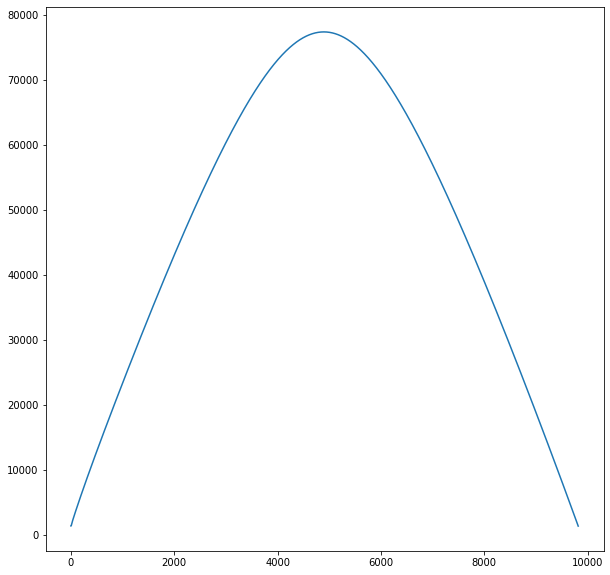

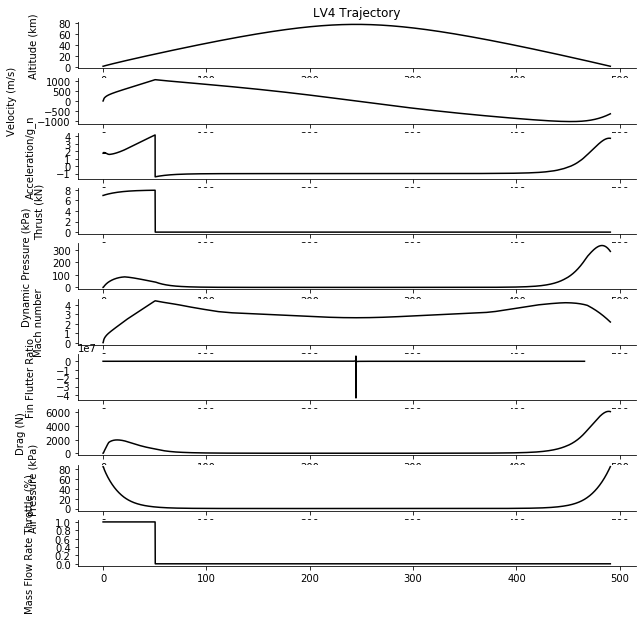

NameError: name 'textlist' is not defined

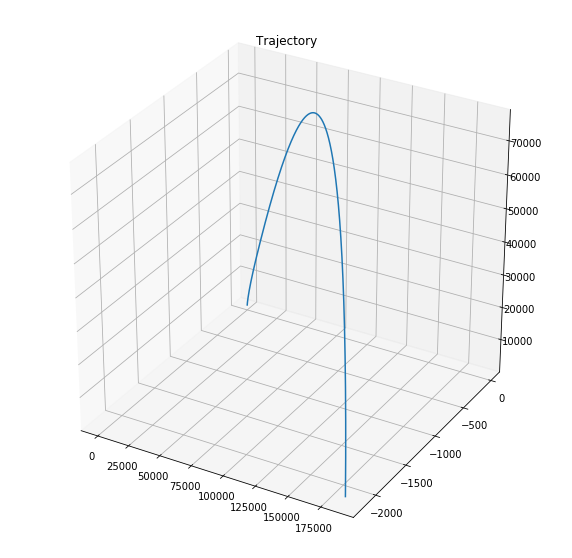

In [9]:
# array breakdown:
# state_list[i]: (state, update, stability_margin, m_prop, openrocket_CoM)
#   state: (m, x, q, v, w)
#   update: (derivatives, dynamics)
#     derivatives: see state
#     dynamics: (forces, accels, torque, throttle, air, aero, thrust)
#       air: (p_a, rho, T_a, mu)
#       aero: (force_body, torque_body, v0, dyn_press, Ma, alpha, CoP[2], flutter)

# this block is so that our notebook won't automatically run a sim when it is imported ;)
if __name__ == '__main__' and not '__file__' in globals():
    #from matplotlib import pyplot as plt

    fig, ax1 = plt.subplots()
    #ax1.plot(test.LV4.dt[:])
    #ax1.plot(test.LV4.error)
    #axs.plot(test.w) # test.LV4.length-
    #ax1.plot([test.LV4.length- state[2][3][6] for state in test.states[1:]])
    #ax1.plot([2*np.arccos(state[0][2][0])*180/np.pi for state in test_run.raw_states[1:]])
    ax1.plot(#[state[0][1][0] for state in test_run.raw_states[1:]],
             [state[0][1][2] for state in test_run.raw_states[1:]])
    #plt.show()
    #print(max([test.LV4.length- state[2][3][6] for state in test.states[1:]]))
    #print(min([test.LV4.length- state[2][3][6] for state in test.states[1:2000]]))
    #print(test.LV4.length)
    #textlist = print_results(test_run, False)
    rocket_plot(test_run.t, test_run.alt, test_run.v, test_run.a, test_run.thrust, test_run.dyn_press,
                test_run.Ma, test_run.m, test_run.p_a, test_run.drag, test_run.throttle, test_run.fin_flutter, False)
    
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(1)
    ax = fig.add_subplot(111, projection='3d')
    xyz = [state[0][1] for state in test_run.raw_states]
    x, y, z = [state[0] for state in xyz], [state[1] for state in xyz], [state[2] for state in xyz]
    ax.plot(x, y, z)
    ax.grid()
    plt.title('Trajectory')
    for line in textlist:
        print(line)